In [2]:
import os
import random

import librosa
from tqdm import tqdm
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2ForXVector, AutoFeatureExtractor, Wav2Vec2Model
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

In [3]:
data_path = '/workspace/ssd/AI_hub/speech_recognition/dataset/test.txt'

In [4]:
dataset_name = 'VoiceDatasetWav2Vec'
model_name = 'facebook/wav2vec2-base-960h'
num_workers = 8
seed_number = 42

In [5]:
class VoiceDatasetWav2Vec(Dataset):
    def __init__(self, data_path, max_length, model_name):
        self.data_path = data_path
        self.max_length = max_length
        self.feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
        self.data = []            # 전체 데이터
        self.speaker_files = []   # 총 화자
        self.speaker_datas = {}   # 각 화자에 대한 데이터
        
        with open(self.data_path, 'r') as f:
            for line in f:
                self.speaker_files.append(line.strip())
                
        for txt_file in self.speaker_files:
            speaker_id = os.path.basename(txt_file).split('.')[0]
            with open(txt_file, 'r') as f:
                self.speaker_datas[speaker_id] = [line.strip() for line in f]
        
        for files in self.speaker_datas.values():
            self.data.extend(files)


    def load_audio(self, file_path):
        audio, sampling_rate = librosa.load(file_path, sr=16000)
        inputs = self.feature_extractor(audio, sampling_rate=sampling_rate, max_length=int(self.max_length * sampling_rate), truncation=True, padding="max_length", return_tensors="pt")
        return inputs.input_values.squeeze(0)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        anchor_data = self.data[idx]
        anchor_audio = self.load_audio(anchor_data)
        
        # speaker_id 추출
        speaker_id = os.path.basename(os.path.dirname(anchor_data))
        each_speaker_datas = self.speaker_datas[speaker_id]
        
        # Positive pair는 같은 화자의 파일들 중 랜덤으로 선택
        positive_data = random.choice([x for x in each_speaker_datas if x != anchor_data])
        positive_audio = self.load_audio(positive_data)
        
        # Negative pair는 다른 화자의 파일들 중 랜덤으로 선택
        negative_speaker_ids = [other_speaker_id for other_speaker_id in self.speaker_datas.keys() if other_speaker_id != speaker_id]
        negative_speaker_id = random.choice(negative_speaker_ids)
        negative_data = random.choice(self.speaker_datas[negative_speaker_id])
        negative_audio = self.load_audio(negative_data)

        return anchor_audio, positive_audio, negative_audio

In [6]:
valid_dataset = VoiceDatasetWav2Vec(data_path, 4.0, model_name)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [7]:
def calculate_similarity(embedding1, embedding2):
    return F.cosine_similarity(embedding1, embedding2).cpu().numpy()

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
model = Wav2Vec2Model.from_pretrained(model_name)
model.load_state_dict(torch.load('./finetuned_model/wav2vecModel_wav2vec2-base-960h/best_model.pth'))
model.to(device)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=768, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
  

In [11]:
model.eval()
similarities = []
labels = []

In [ ]:
## wav2vec2Model-base-960

In [12]:
valid_progress_bar = tqdm(valid_dataloader)
for idx, batch in enumerate(valid_progress_bar):
    anchor, positive, negative = batch
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    with torch.no_grad():
        anchor_embeddings = model(anchor).last_hidden_state.mean(dim=1)
        positive_embeddings = model(positive).last_hidden_state.mean(dim=1)
        negative_embeddings = model(negative).last_hidden_state.mean(dim=1)

    pos_similirarity = calculate_similarity(anchor_embeddings, positive_embeddings)
    neg_similirarity = calculate_similarity(anchor_embeddings, negative_embeddings)

    similarities.extend(pos_similirarity)
    similarities.extend(neg_similirarity)
    labels.extend([1] * len(pos_similirarity))
    labels.extend([0] * len(neg_similirarity))

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# Calculate F1 score at the optimal threshold
binary_predictions = (similarities > best_threshold).astype(int)
f1 = f1_score(labels, binary_predictions)

print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

100%|██████████| 28069/28069 [45:52<00:00, 10.20it/s]


ROC AUC: 0.9746, Best Threshold: 0.3290, F1 Score: 0.9328


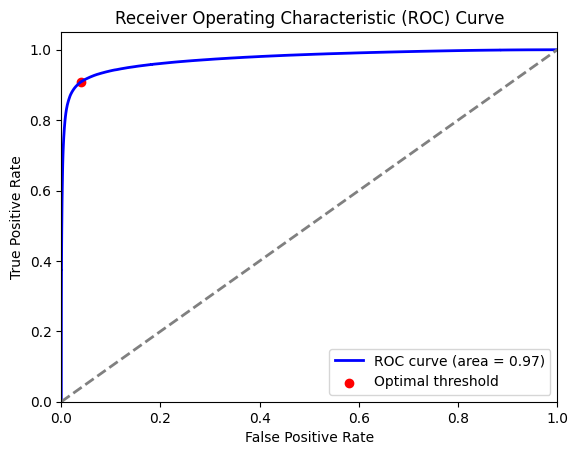

In [13]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [14]:
from transformers import Wav2Vec2ForXVector, AutoModelForAudioXVector

In [15]:
model_name = 'anton-l/wav2vec2-base-superb-sv'

In [16]:
model = AutoModelForAudioXVector.from_pretrained(model_name).to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:835: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of the model checkpoint at anton-l/wav2vec2-base-superb-sv were not used when initializing Wav2Vec2ForXVector: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForXVector from the checkpoint of a model trained 

In [17]:
model.eval()
similarities = []
labels = []

In [18]:
valid_progress_bar = tqdm(valid_dataloader)
for idx, batch in enumerate(valid_progress_bar):
    anchor, positive, negative = batch
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    with torch.no_grad():
        anchor_embeddings = model(anchor).embeddings
        positive_embeddings = model(positive).embeddings
        negative_embeddings = model(negative).embeddings

    pos_similirarity = calculate_similarity(anchor_embeddings, positive_embeddings)
    neg_similirarity = calculate_similarity(anchor_embeddings, negative_embeddings)

    similarities.extend(pos_similirarity)
    similarities.extend(neg_similirarity)
    labels.extend([1] * len(pos_similirarity))
    labels.extend([0] * len(neg_similirarity))

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# Calculate F1 score at the optimal threshold
binary_predictions = (similarities > best_threshold).astype(int)
f1 = f1_score(labels, binary_predictions)

print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

100%|██████████| 28069/28069 [49:16<00:00,  9.49it/s]


ROC AUC: 0.6735, Best Threshold: 0.7795, F1 Score: 0.6197


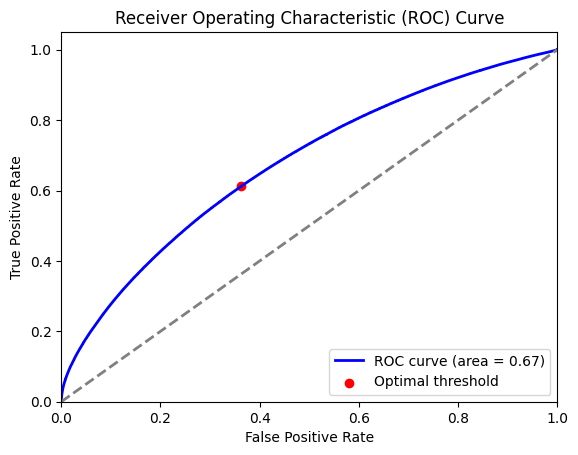

In [19]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [16]:
model_name = 'facebook/wav2vec2-large'

In [17]:
model = Wav2Vec2Model.from_pretrained(model_name)
model.load_state_dict(torch.load('./finetuned_model/wav2vecModel_wav2vec2-large/best_model.pth'))
model.to(device)

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2GroupNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (activation): GELUActivation()
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
      )
      (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Wav2Vec2Encoder(
    (pos_conv_embed): Wav2Vec2PositionalConvEmbedding(
 

In [18]:
model.eval()
similarities = []
labels = []

In [19]:
valid_progress_bar = tqdm(valid_dataloader)
for idx, batch in enumerate(valid_progress_bar):
    anchor, positive, negative = batch
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    with torch.no_grad():
        anchor_embeddings = model(anchor).last_hidden_state.mean(dim=1)
        positive_embeddings = model(positive).last_hidden_state.mean(dim=1)
        negative_embeddings = model(negative).last_hidden_state.mean(dim=1)

    pos_similirarity = calculate_similarity(anchor_embeddings, positive_embeddings)
    neg_similirarity = calculate_similarity(anchor_embeddings, negative_embeddings)

    similarities.extend(pos_similirarity)
    similarities.extend(neg_similirarity)
    labels.extend([1] * len(pos_similirarity))
    labels.extend([0] * len(neg_similirarity))

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# Calculate F1 score at the optimal threshold
binary_predictions = (similarities > best_threshold).astype(int)
f1 = f1_score(labels, binary_predictions)

print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

 49%|████▉     | 13821/28069 [54:37<55:32,  4.28it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 92%|█████████▏| 25843/28069 [1:41:26<08:39,  4.29it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
## wav2vec2Model-large

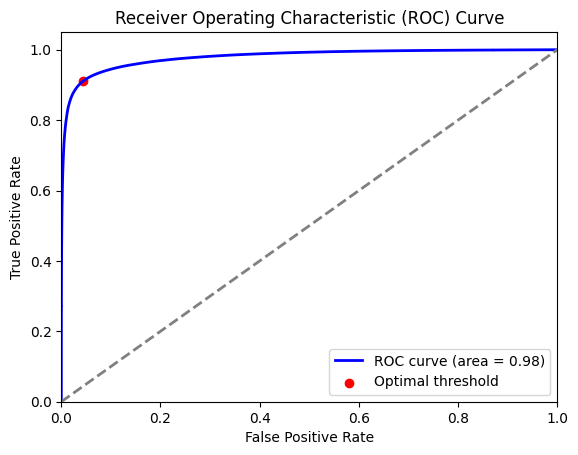

In [20]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [21]:
model_name = 'facebook/wav2vec2-large-960h-lv60'

In [22]:
model = Wav2Vec2Model.from_pretrained(model_name)
model.load_state_dict(torch.load('./finetuned_model/wav2vecModel_wav2vec2-large-960h-lv60/best_model_60.pth'))
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-960h-lv60 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [23]:
model.eval()
similarities = []
labels = []./finetuned_model/wav2vecModel_wav2vec2-large-960h-lv60/

In [24]:
valid_progress_bar = tqdm(valid_dataloader)
for idx, batch in enumerate(valid_progress_bar):
    anchor, positive, negative = batch
    anchor = anchor.to(device)
    positive = positive.to(device)
    negative = negative.to(device)

    with torch.no_grad():
        anchor_embeddings = model(anchor).last_hidden_state.mean(dim=1)
        positive_embeddings = model(positive).last_hidden_state.mean(dim=1)
        negative_embeddings = model(negative).last_hidden_state.mean(dim=1)

    pos_similirarity = calculate_similarity(anchor_embeddings, positive_embeddings)
    neg_similirarity = calculate_similarity(anchor_embeddings, negative_embeddings)

    similarities.extend(pos_similirarity)
    similarities.extend(neg_similirarity)
    labels.extend([1] * len(pos_similirarity))
    labels.extend([0] * len(neg_similirarity))

# Calculate ROC AUC
fpr, tpr, thresholds = roc_curve(labels, similarities)
roc_auc = auc(fpr, tpr)

# Calculate Youden's J statistic to find the optimal threshold
J = tpr - fpr
ix = np.argmax(J)
best_threshold = thresholds[ix]

# Calculate F1 score at the optimal threshold
binary_predictions = (similarities > best_threshold).astype(int)
f1 = f1_score(labels, binary_predictions)

print(f'ROC AUC: {roc_auc:.4f}, Best Threshold: {best_threshold:.4f}, F1 Score: {f1:.4f}')

100%|██████████| 28069/28069 [2:06:15<00:00,  3.71it/s]  


ROC AUC: 0.9818, Best Threshold: 0.3743, F1 Score: 0.9366


In [ ]:
## wav2vec2Model-large-960-lv60

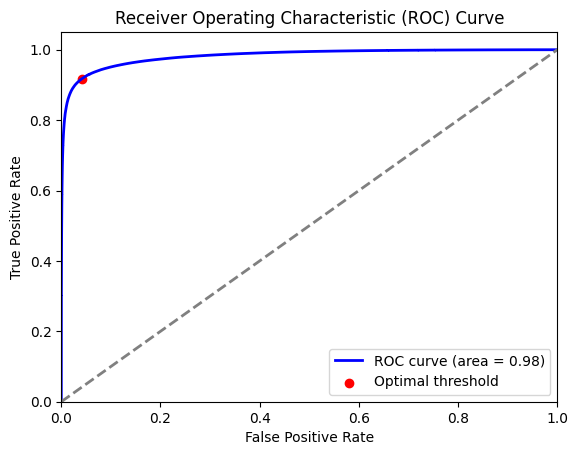

In [25]:
# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], color='red', marker='o', label='Optimal threshold')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()